In [5]:
%load_ext autoreload
%autoreload

import pandas as pd; pd.set_option('display.max_columns', 30); pd.set_option('display.max_rows', 100)
import numpy as np
from cmlreaders import CMLReader, get_data_index
import ptsa
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sb
from pylab import *
from copy import copy
from scipy import stats
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/SWRrefactored/code/SWR_modules/')
from SWRmodule import *
from general import * #superVstack,findInd,findAinB
from power_functions import z_score, process_power, load_z_scored_power

base = '/home1/john/SWRrefactored'
sys.path.append(f'{base}/code/')

from load_data_numpy import load_data_np
from SWRmodule import triangleSmooth
# from comodulogram import remove_session_string, get_filtered_signal
# from fooof import FOOOF

import statsmodels.formula.api as smf
from scipy.signal import decimate, resample, hilbert, welch, spectrogram
from mne.time_frequency import tfr_array_morlet

# # Import the time & event model objects and Bands object to manage oscillation band definitions
# from specparam import SpectralTimeModel, SpectralTimeEventModel, Bands
# # Import helper utilities for simulating and plotting spectrograms
# from specparam.sim import sim_spectrogram
# from specparam.plts.spectra import plot_spectrogram

# np.logspace(np.log10(80),np.log10(178),10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# for now the plotting code only works with one region at a time
region_name = ['HPC'] # ['ENT'] # ['AMY'] ['HPC']
subregion = ['ca1'] #['ca1'] # can use [''] to select ALL subregions
task = 'catFR1' # 'catFR1'
savePath = f'{base}/figures/'

# 1 for encoding, 0 for recall
encoding_mode_arr = [1] #,1] #[0,1] "
freq_range_str_arr = [[33.5,75]] #,[7,9],[33.5,75],[80,120]] #[[33.5,75],[80,120]] #,[2,4],[7,9]] # [80,178]
# these were selecetd to avoid 60 and 120 Hz using np.logspace(np.log10(30),np.log10(75),10)

fs = 500 # sampling rate for raw data and ripples from createEventsForDF.py

In [7]:
for encoding_mode in encoding_mode_arr:

    dd_trials = load_data_np(encoding_mode,task,
        region_name=region_name, train_only=False, subregion=subregion)

    region_str = region_name[0]
    subregion_str = subregion[0]
    
    clust = dd_trials['clust_int']
    
    start_cutoff = 0 # in samples
    if encoding_mode == 1: # raw is from -1.7 to 3.3 s from word_on
        saveName = 'encoding_'
        recall_str = ''
        correct = dd_trials['correct']
        incorrect_idxs = np.argwhere(correct==0).squeeze()
        end_cutoff = 2500 # just take the whole range of data to better estimate Morlet     
 
    elif encoding_mode == 0: # raw is from -3 to 3 s from recall
        saveName = 'recall_'
        recall_str = '_recall'
        end_cutoff = 3000 # just take the whole range of data to better estimate Morlet       

    sr_factor = 1000/fs
    
    # Generate power_z
    
    load_anew = 0 # load power_z anew without saving or loading from previous runs
    
    print("Generating figures for run_mode: ", encoding_mode)
    power_z = None  # Initialize power_z as None
    if load_anew == 1: # if encoding need to save in pieces
        # for recall can load them all together in power_z
        power_z = load_z_scored_power(dd_trials, freq_range_str_arr, encoding_mode,fs,start_cutoff, end_cutoff)
    else:
        for freq in freq_range_str_arr:
            saved_power_z_fn = f'/scratch/john/SWRrefactored/temp_dat/power_z_{task}_{saveName}{region_name[0]}_{subregion[0]}_freq{freq[0]}.npz'
            
            if power_z is None:
                if os.path.exists(saved_power_z_fn):
                    # Loading the file without creating a full copy in memory
                    power_z = np.load(saved_power_z_fn, mmap_mode='r')['power_z']
                else: # if hasn't been made yet: create power_z anew
                    power_z = load_z_scored_power(dd_trials, [freq], encoding_mode, fs, start_cutoff, end_cutoff)
                    power_z = np.expand_dims(power_z, axis=0)  # Add the first dimension
                    np.savez_compressed(saved_power_z_fn, power_z=power_z)
            else:
                if os.path.exists(saved_power_z_fn):
                    # Load the next frequency data directly into a new slice of power_z
                    next_slice = np.load(saved_power_z_fn, mmap_mode='r')['power_z']
                else:
                    next_slice = load_z_scored_power(dd_trials, [freq], encoding_mode, fs, start_cutoff, end_cutoff)
                    next_slice = np.expand_dims(next_slice, axis=0)  # Add the first dimension
                    np.savez_compressed(saved_power_z_fn, power_z=next_slice)
                # Append next_slice along the first dimension by expanding power_z
                import gc # import garbage collection
                power_z = np.concatenate((power_z, next_slice), axis=0)   
                del next_slice # delete and trigger garbage collection
                gc.collect()
        
    # note that output is 50 Hz (20 ms bins) since started 500 hz and decimated 10x
    if len(subregion[0]) > 0:
        subregion_str = f'_{subregion[0]}'
    else:
        subregion_str = ''           

a=1;            

Loading data
LOADING DATA FROM: HPC FOR EXPERIMENT catFR1


/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


order: C


/home1/john/SWRrefactored/code/SWR_modules/load_data.py:436: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dd_trials[key] = np.asarray(val)


Generating figures for run_mode:  1


In [8]:
# info
dd_trials.keys()
np.shape(dd_trials['ripple'])
np.shape(dd_trials['raw'])

np.shape(power_z)
freq_range_str_arr

unique_subs = np.unique(dd_trials['subj'])
unique_subs

dict_keys(['ripple', 'clust', 'correct', 'recall_pos', 'list_num', 'subj', 'sess', 'elec_names', 'elec_labels', 'serial_pos', 'raw', 'elec_by_elec_correlation', 'trial_by_trial_correlation', 'elec_ripple_rate_array', 'category_array', 'clust_int'])

(117768, 1500)

(117768, 2500)

(1, 117768, 250)

[[33.5, 75]]

array(['R1004D', 'R1015J', 'R1024E', 'R1031M', 'R1032D', 'R1035M',
       'R1045E', 'R1061T', 'R1065J', 'R1066P', 'R1086M', 'R1089P',
       'R1092J', 'R1102P', 'R1105E', 'R1108J', 'R1112M', 'R1131M',
       'R1138T', 'R1144E', 'R1147P', 'R1157C', 'R1158T', 'R1163T',
       'R1171M', 'R1174T', 'R1176M', 'R1188C', 'R1192C', 'R1201P',
       'R1204T', 'R1207J', 'R1217T', 'R1226D', 'R1228M', 'R1230J',
       'R1236J', 'R1243T', 'R1245E', 'R1254E', 'R1260D', 'R1261P',
       'R1269E', 'R1271P', 'R1275D', 'R1278E', 'R1279P', 'R1293P',
       'R1310J', 'R1313J', 'R1315T', 'R1330D', 'R1332M', 'R1338T',
       'R1342M', 'R1343J', 'R1348J', 'R1354E', 'R1366J', 'R1367D',
       'R1368T', 'R1374T', 'R1376D', 'R1382T', 'R1383J', 'R1385E',
       'R1387E', 'R1388T', 'R1396T', 'R1397D', 'R1398J', 'R1413D',
       'R1445E', 'R1448T', 'R1449T', 'R1456D', 'R1465D', 'R1468J',
       'R1472T', 'R1476J', 'R1486J', 'R1488T', 'R1497T', 'R1501J',
       'R1515T', 'R1518T', 'R1525J', 'R1527J', 'R1533J', 'R153

In [17]:
gamma_sd_thresh = 2.0
remove_first_recalls = 0 # if looking at recall might want to remove first recall of each list

# select a patient?
patient_idx = -1 # -1 means all

if patient_idx >-1: 
    sub_idxs = dd_trials['subj']==unique_subs[patient_idx]
else:
    sub_idxs = np.ones(len(dd_trials['subj']),dtype=bool)
print(f'Number of trials: {sum(sub_idxs)} from the following subs:')
np.unique(dd_trials['subj'][sub_idxs])

# if recalls remove the intrusions
if encoding_mode == 0:
    if remove_first_recalls:
        final_sub_idxs = (sub_idxs) & (clust!=0) & (dd_trials['recall_pos']!=1)
    else:
        final_sub_idxs = (sub_idxs) & (clust!=0)
else:
    final_sub_idxs = sub_idxs
      
# update each variable with indices
sub_ripples = dd_trials['ripple'][final_sub_idxs] # ripples are detected from -0.7 to 2.3 s @ 500 Hz
if power_z.ndim == 2:
    power_z = power_z[np.newaxis, :, :]
sub_Zs = power_z[:,final_sub_idxs,:]
sub_clust_ID = clust[final_sub_idxs]
np.shape(sub_Zs)

z_factor = sr_factor*10 # z_score was decimated 10x
if encoding_mode == 1:
    ripple_start_offset = -700 # ripple_trials go from -0.7 to 2.3 s (no buffers)
    ripple_analysis_start = 300 # time in ms
    ripple_analysis_end = 1300 # time in ms
    
    # average z-score over time for same range as ripples
    gamma_time_range = slice(int((1700+ripple_analysis_start)/z_factor),int((1700+ripple_analysis_end)/z_factor)) # +1700 since goes from -1.7 to 3.3 s   
    
elif encoding_mode == 0:
    ripple_start_offset = -2000 # ripple matrix 2000 ms on either side of recall
    ripple_analysis_start = -1900 # time in ms
    ripple_analysis_end = -100 # time in ms    

    # average z-score over time for same range as ripples
    gamma_time_range = slice(int((3000+ripple_analysis_start)/z_factor),int((3000+ripple_analysis_end)/z_factor)) # +3000 since goes from -3 to 3 s

# check power > thresh in gamma time range
z_low_gamma_trials = np.mean(sub_Zs[0,:,gamma_time_range],1)>gamma_sd_thresh
if np.shape(sub_Zs)[0]>1:
    z_high_gamma_trials = np.mean(sub_Zs[1,:,gamma_time_range],1)>gamma_sd_thresh     
    
ripple_trials = np.sum(sub_ripples[:,int((-ripple_start_offset+ripple_analysis_start)/sr_factor):
                                   int((-ripple_start_offset+ripple_analysis_end)/sr_factor)],1)>0
print(f'{sum(ripple_trials)} trials have ripples which is {np.round(100*sum(ripple_trials)/sum(final_sub_idxs),2)}% of total')


Number of trials: 117768 from the following subs:


array(['R1004D', 'R1015J', 'R1024E', 'R1031M', 'R1032D', 'R1035M',
       'R1045E', 'R1061T', 'R1065J', 'R1066P', 'R1086M', 'R1089P',
       'R1092J', 'R1102P', 'R1105E', 'R1108J', 'R1112M', 'R1131M',
       'R1138T', 'R1144E', 'R1147P', 'R1157C', 'R1158T', 'R1163T',
       'R1171M', 'R1174T', 'R1176M', 'R1188C', 'R1192C', 'R1201P',
       'R1204T', 'R1207J', 'R1217T', 'R1226D', 'R1228M', 'R1230J',
       'R1236J', 'R1243T', 'R1245E', 'R1254E', 'R1260D', 'R1261P',
       'R1269E', 'R1271P', 'R1275D', 'R1278E', 'R1279P', 'R1293P',
       'R1310J', 'R1313J', 'R1315T', 'R1330D', 'R1332M', 'R1338T',
       'R1342M', 'R1343J', 'R1348J', 'R1354E', 'R1366J', 'R1367D',
       'R1368T', 'R1374T', 'R1376D', 'R1382T', 'R1383J', 'R1385E',
       'R1387E', 'R1388T', 'R1396T', 'R1397D', 'R1398J', 'R1413D',
       'R1445E', 'R1448T', 'R1449T', 'R1456D', 'R1465D', 'R1468J',
       'R1472T', 'R1476J', 'R1486J', 'R1488T', 'R1497T', 'R1501J',
       'R1515T', 'R1518T', 'R1525J', 'R1527J', 'R1533J', 'R153

(1, 117768, 250)

26044 trials have ripples which is 22.11% of total


In [18]:
print(f"{len(np.unique(dd_trials['elec_labels'][sub_idxs]))} elecs")
print(f"from {len(np.unique(dd_trials['sess'][sub_idxs]))} sessions")
print(f"from {len(np.unique(dd_trials['subj'][sub_idxs]))} patients")

if region_name == ['ENT']:
    ENT_sess = np.unique(dd_trials['sess'][sub_idxs])
    ENT_sub = np.unique(dd_trials['subj'][sub_idxs])
elif region_name == ['HPC']:
    HPC_sess = np.unique(dd_trials['sess'][sub_idxs])
    HPC_sub = np.unique(dd_trials['subj'][sub_idxs])
elif region_name == ['AMY']:
    AMY_sess = np.unique(dd_trials['sess'][sub_idxs])
    AMY_sub = np.unique(dd_trials['subj'][sub_idxs])
    
save_sub_sess_info = 0

if save_sub_sess_info == 1:
    import pickle
    with open('../misc/region_data.pkl', 'wb') as f:
        pickle.dump({
            'ENT_sess': ENT_sess,
            'ENT_sub': ENT_sub,
            'HPC_sess': HPC_sess,
            'HPC_sub': HPC_sub,
            'AMY_sess': AMY_sess,
            'AMY_sub': AMY_sub
        }, f)   

570 elecs
from 189 sessions
from 99 patients


### get start_array!

In [19]:
start_array,_ = getStartEndArrays(sub_ripples)

# first bin has artificially high number due to how start_srray works
start_array = start_array[:,1:] 
print(f'start array shape: {np.shape(start_array)}')

start array shape: (117768, 1499)


In [20]:
dd_trials['elec_labels']
len(dd_trials['elec_labels'][final_sub_idxs])
len(dd_trials['subj'][final_sub_idxs])
len(dd_trials['sess'][final_sub_idxs])
np.shape(sub_Zs)
len(sub_clust_ID)

array(['R1525J-0_RA1-RA2', 'R1525J-0_RA3-RA4', 'R1525J-0_RA4-RA5', ...,
       'R1680T-3_LB3-LB4', 'R1680T-3_LB1-LB2', 'R1680T-3_LB3-LB4'],
      dtype='<U24')

117768

117768

117768

(1, 117768, 250)

117768

# ripples after removing low gamma trials

In [13]:
remove_low_freq = 1 # 1 for low gamma/theta; 2 for high gamma/theta

/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1410: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  norm_count = count/np.array((num_trials*binsize/1000))


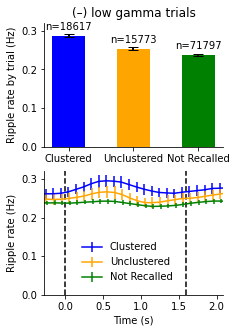

In [78]:
import matplotlib.gridspec as gridspec

# Function parameters
bin_size = 100  # in ms
smoothing_triangle = 7  # triangular smoothing window width

bar_ylimits = (0, 0.32)

if remove_low_freq == 1:
    trial_select = ~z_low_gamma_trials
elif remove_low_freq == 2:
    trial_select = ~z_high_gamma_trials
else:
    print('Invalid remove_low_freq selection')
    error    

ripple_swarm_start = int((-ripple_start_offset+ripple_analysis_start)/sr_factor)
ripple_swarm_end = int((-ripple_start_offset+ripple_analysis_end)/sr_factor)
ripple_swarm_duration = (ripple_analysis_end-ripple_analysis_start)/1000  # convert to seconds

# Apply the clust variable to split data into clustered, unclustered, and not recalled
clust_clustered = sub_clust_ID > 1
clust_unclustered = sub_clust_ID < 0
clust_not_recalled = sub_clust_ID == 0

# Calculate ripple means and standard errors for each condition
mean_ripple_clustered = np.sum(start_array[trial_select & clust_clustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_unclustered = np.sum(start_array[trial_select & clust_unclustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_not_recalled = np.sum(start_array[trial_select & clust_not_recalled, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration

if encoding_mode == 1:
    means = [np.mean(mean_ripple_clustered), np.mean(mean_ripple_unclustered), np.mean(mean_ripple_not_recalled)]
    ses = [np.std(mean_ripple_clustered) / np.sqrt(len(mean_ripple_clustered)),
           np.std(mean_ripple_unclustered) / np.sqrt(len(mean_ripple_unclustered)),
           np.std(mean_ripple_not_recalled) / np.sqrt(len(mean_ripple_not_recalled))]
    fig = plt.figure(figsize=(3.2, 5))
elif encoding_mode == 0:
    means = [np.mean(mean_ripple_clustered), np.mean(mean_ripple_unclustered)]
    ses = [np.std(mean_ripple_clustered) / np.sqrt(len(mean_ripple_clustered)),
           np.std(mean_ripple_unclustered) / np.sqrt(len(mean_ripple_unclustered))]    
    fig = plt.figure(figsize=(2.5, 5))

# Define the palette for colors
palette = {
    'Clustered': 'blue',
    'Unclustered': 'orange',
    'Not Recalled': 'green'
}

# Set up the figure with GridSpec
gs = gridspec.GridSpec(2, 3, height_ratios=[2, 2], width_ratios=[3, 3, 3])

# Create the bar plot with error bars (span all columns)
ax_bar = fig.add_subplot(gs[0, :])
if encoding_mode == 1:
    xlabels = ['Clustered', 'Unclustered', 'Not Recalled']
    xcolors = [palette['Clustered'], palette['Unclustered'], palette['Not Recalled']]
elif encoding_mode == 0:
    xlabels = ['Clustered', 'Unclustered']
    xcolors = [palette['Clustered'], palette['Unclustered']]
bars = ax_bar.bar(x=xlabels, 
                  height=means, 
                  color=xcolors, 
                  yerr=ses, 
                  width=0.5,  # Adjust width to make bars tighter
                  capsize=5, 
                  error_kw=dict(ecolor='black', elinewidth=2))

ax_bar.set_ylabel('Ripple rate by trial (Hz)')
ax_bar.set_xlabel('')
ax_bar.set_ylim(bar_ylimits)
ax_bar.set_xticklabels(['Clustered', 'Unclustered', 'Not Recalled'], rotation=0, ha="center")
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['top'].set_visible(False)
ax_bar.set_title('(–) low gamma trials')

# Add the number of trials above each bar
n_trials = [np.sum(trial_select & clust_clustered), 
            np.sum(trial_select & clust_unclustered), 
            np.sum(trial_select & clust_not_recalled)]
for bar, n in zip(bars, n_trials):
    ax_bar.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'n={n}', ha='center', va='bottom')

# Calculate PSTH for each group
ripple_PSTH_clustered, bin_centers = fullPSTH(start_array[trial_select & clust_clustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_unclustered, _ = fullPSTH(start_array[trial_select & clust_unclustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_not_recalled, _ = fullPSTH(start_array[trial_select & clust_not_recalled], bin_size, smoothing_triangle, fs, ripple_start_offset)

# Bin the start_array to match the PSTH
n_bins = len(bin_centers)
binned_start_array = np.array_split(start_array[trial_select & clust_clustered], n_bins, axis=1)

# Calculate the mean and SE for each bin
se_clustered = [np.std(bin_data*fs, axis=1) / np.sqrt(bin_data.shape[0]) for bin_data in binned_start_array]
se_clustered = np.mean(se_clustered, axis=1)

binned_start_array_unclustered = np.array_split(start_array[trial_select & clust_unclustered], n_bins, axis=1)
se_unclustered = [np.std(bin_data*fs, axis=1) / np.sqrt(bin_data.shape[0]) for bin_data in binned_start_array_unclustered]
se_unclustered = np.mean(se_unclustered, axis=1)

if encoding_mode == 1:
    binned_start_array_not_recalled = np.array_split(start_array[trial_select & clust_not_recalled], n_bins, axis=1)
    se_not_recalled = [np.std(bin_data*fs, axis=1) / np.sqrt(bin_data.shape[0]) for bin_data in binned_start_array_not_recalled]
    se_not_recalled = np.mean(se_not_recalled, axis=1)

# Plot the PSTH for each group with error bars
ax_psth = fig.add_subplot(gs[1, :])
ax_psth.errorbar(bin_centers / 1000-0.01, ripple_PSTH_clustered, yerr=se_clustered, label='Clustered', color=palette['Clustered'], capsize=0)
ax_psth.errorbar(bin_centers / 1000, ripple_PSTH_unclustered, yerr=se_unclustered, label='Unclustered', color=palette['Unclustered'], capsize=0)
if encoding_mode == 1:
    ax_psth.errorbar(bin_centers / 1000+0.01, ripple_PSTH_not_recalled, yerr=se_not_recalled, label='Not Recalled', color=palette['Not Recalled'], capsize=0)
    ax_psth.axvline(x=0.0, color='black', linestyle='--')
    ax_psth.axvline(x=1.6, color='black', linestyle='--')
    ax_psth.set_xlim(-0.28, 2.08)
elif encoding_mode == 0:
    ax_psth.set_xlim(-2.0, 2.0)
ax_psth.set_xlabel('Time (s)')
ax_psth.set_ylim(0, bar_ylimits[1])
ax_psth.set_ylabel('Ripple rate (Hz)')
ax_psth.spines['right'].set_visible(False)
ax_psth.spines['top'].set_visible(False)

# Add legend to the bottom plot
ax_psth.legend(bbox_to_anchor=(0.77,0.5), frameon=False)

# plt.tight_layout()
plt.show()
a=1;

# ripples only for + low gamma trials

/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1410: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  norm_count = count/np.array((num_trials*binsize/1000))


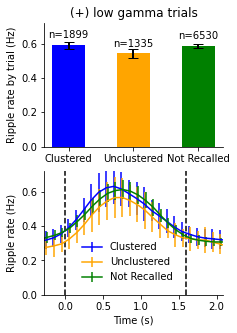

In [77]:
# Function parameters
bin_size = 100  # in ms
smoothing_triangle = 7  # triangular smoothing window width

bar_ylimits = (0, 0.72)

if remove_low_freq == 1:
    trial_select = z_low_gamma_trials
elif remove_low_freq == 2:
    trial_select = z_high_gamma_trials
else:
    print('Invalid remove_low_freq selection')
    error

ripple_swarm_start = int((-ripple_start_offset+ripple_analysis_start)/sr_factor)
ripple_swarm_end = int((-ripple_start_offset+ripple_analysis_end)/sr_factor)
ripple_swarm_duration = (ripple_analysis_end-ripple_analysis_start)/1000  # convert to seconds

# Apply the clust variable to split data into clustered, unclustered, and not recalled
clust_clustered = sub_clust_ID > 1
clust_unclustered = sub_clust_ID < 0
clust_not_recalled = sub_clust_ID == 0

# Calculate ripple means and standard errors for each condition
mean_ripple_clustered = np.sum(start_array[trial_select & clust_clustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_unclustered = np.sum(start_array[trial_select & clust_unclustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_not_recalled = np.sum(start_array[trial_select & clust_not_recalled, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration

if encoding_mode == 1:
    means = [np.mean(mean_ripple_clustered), np.mean(mean_ripple_unclustered), np.mean(mean_ripple_not_recalled)]
    ses = [np.std(mean_ripple_clustered) / np.sqrt(len(mean_ripple_clustered)),
           np.std(mean_ripple_unclustered) / np.sqrt(len(mean_ripple_unclustered)),
           np.std(mean_ripple_not_recalled) / np.sqrt(len(mean_ripple_not_recalled))]
    fig = plt.figure(figsize=(3.2, 5))
elif encoding_mode == 0:
    means = [np.mean(mean_ripple_clustered), np.mean(mean_ripple_unclustered)]
    ses = [np.std(mean_ripple_clustered) / np.sqrt(len(mean_ripple_clustered)),
           np.std(mean_ripple_unclustered) / np.sqrt(len(mean_ripple_unclustered))]    
    fig = plt.figure(figsize=(2.5, 5))

# Define the palette for colors
palette = {
    'Clustered': 'blue',
    'Unclustered': 'orange',
    'Not Recalled': 'green'
}

# Set up the figure with GridSpec
gs = gridspec.GridSpec(2, 3, height_ratios=[2, 2], width_ratios=[3, 3, 3])

# Create the bar plot with error bars (span all columns)
ax_bar = fig.add_subplot(gs[0, :])
if encoding_mode == 1:
    xlabels = ['Clustered', 'Unclustered', 'Not Recalled']
    xcolors = [palette['Clustered'], palette['Unclustered'], palette['Not Recalled']]
elif encoding_mode == 0:
    xlabels = ['Clustered', 'Unclustered']
    xcolors = [palette['Clustered'], palette['Unclustered']]
bars = ax_bar.bar(x=xlabels, 
                  height=means, 
                  color=xcolors, 
                  yerr=ses, 
                  width=0.5,  # Adjust width to make bars tighter
                  capsize=5, 
                  error_kw=dict(ecolor='black', elinewidth=2))

ax_bar.set_ylabel('Ripple rate by trial (Hz)')
ax_bar.set_xlabel('')
ax_bar.set_ylim(bar_ylimits)
ax_bar.set_xticklabels(xlabels, rotation=0, ha="center")
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['top'].set_visible(False)
ax_bar.set_title('(+) low gamma trials')

# Add the number of trials above each bar
n_trials = [np.sum(trial_select & clust_clustered), 
            np.sum(trial_select & clust_unclustered), 
            np.sum(trial_select & clust_not_recalled)]
for bar, n in zip(bars, n_trials):
    ax_bar.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.03, f'n={n}', ha='center', va='bottom')

# Calculate PSTH for each group
ripple_PSTH_clustered, bin_centers = fullPSTH(start_array[trial_select & clust_clustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_unclustered, _ = fullPSTH(start_array[trial_select & clust_unclustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_not_recalled, _ = fullPSTH(start_array[trial_select & clust_not_recalled], bin_size, smoothing_triangle, fs, ripple_start_offset)

# Bin the start_array to match the PSTH
n_bins = len(bin_centers)
binned_start_array = np.array_split(start_array[trial_select & clust_clustered], n_bins, axis=1)

# Calculate the mean and SE for each bin
se_clustered = [np.std(bin_data*fs, axis=1) / np.sqrt(bin_data.shape[0]) for bin_data in binned_start_array]
se_clustered = np.mean(se_clustered, axis=1)

binned_start_array_unclustered = np.array_split(start_array[trial_select & clust_unclustered], n_bins, axis=1)
se_unclustered = [np.std(bin_data*fs, axis=1) / np.sqrt(bin_data.shape[0]) for bin_data in binned_start_array_unclustered]
se_unclustered = np.mean(se_unclustered, axis=1)

if encoding_mode == 1:
    binned_start_array_not_recalled = np.array_split(start_array[trial_select & clust_not_recalled], n_bins, axis=1)
    se_not_recalled = [np.std(bin_data*fs, axis=1) / np.sqrt(bin_data.shape[0]) for bin_data in binned_start_array_not_recalled]
    se_not_recalled = np.mean(se_not_recalled, axis=1)

# Plot the PSTH for each group with error bars
ax_psth = fig.add_subplot(gs[1, :])
ax_psth.errorbar(bin_centers / 1000-0.01, ripple_PSTH_clustered, yerr=se_clustered, label='Clustered', color=palette['Clustered'], capsize=0)
ax_psth.errorbar(bin_centers / 1000, ripple_PSTH_unclustered, yerr=se_unclustered, label='Unclustered', color=palette['Unclustered'], capsize=0)
if encoding_mode == 1:
    ax_psth.errorbar(bin_centers / 1000+0.01, ripple_PSTH_not_recalled, yerr=se_not_recalled, label='Not Recalled', color=palette['Not Recalled'], capsize=0)
    ax_psth.axvline(x=0.0, color='black', linestyle='--')
    ax_psth.axvline(x=1.6, color='black', linestyle='--')
    ax_psth.set_xlim(-0.28, 2.08)
elif encoding_mode == 0:
    ax_psth.set_xlim(-2.0, 2.0)
ax_psth.set_xlabel('Time (s)')
ax_psth.set_ylim(0, bar_ylimits[1])
ax_psth.set_ylabel('Ripple rate (Hz)')
ax_psth.spines['right'].set_visible(False)
ax_psth.spines['top'].set_visible(False)

# Add legend to the bottom plot
ax_psth.legend(bbox_to_anchor=(0.77,0.5), frameon=False)

# Adjust layout
# plt.tight_layout()
plt.show()
a=1;

In [86]:
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# Flatten the ripple data for easier modeling
ripple_data = start_array[:, ripple_swarm_start:ripple_swarm_end].sum(axis=1)

# Create a DataFrame with the data
df = pd.DataFrame({
    'ripple_rate': ripple_data,
    'clust_clustered': (sub_clust_ID > 1).astype(int),
    'clust_unclustered': (sub_clust_ID < 0).astype(int),
    'clust_not_recalled': (sub_clust_ID == 0).astype(int),
    'session': dd_trials['sess'][final_sub_idxs],
    'subject': dd_trials['subj'][final_sub_idxs],
    'low_gamma': z_low_gamma_trials,
})
if remove_low_freq == 2:
    df['high_gamma'] = z_high_gamma_trials

# Define the model formula
# 'ripple_rate ~ clust_clustered + clust_unclustered + clust_not_recalled' specifies the fixed effects
# '(1 | subject/session)' specifies the random effects, with session nested within subject
if encoding_mode == 1:
    formula = "ripple_rate ~ clust_clustered + clust_unclustered"
elif encoding_mode == 0:
    formula = "ripple_rate ~ clust_clustered" # since not recalled doesn't exist
model = mixedlm(
    formula=formula,data=df, groups=df["subject"], vc_formula={"session": "0 + session"})

print(model.fit().summary())

           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  ripple_rate
No. Observations:  81984    Method:              REML       
No. Groups:        100      Scale:               0.1816     
Min. group size:   84       Log-Likelihood:      -46744.6332
Max. group size:   3360     Converged:           Yes        
Mean group size:   819.8                                    
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.138    0.008 17.820 0.000  0.123  0.153
clust_clustered    0.000    0.004  0.016 0.987 -0.009  0.009
clust_unclustered -0.005    0.005 -1.005 0.315 -0.013  0.004
session Var        0.012    0.003                           



In [87]:
if encoding_mode == 1:
    if remove_low_freq == 1:
        formula = "ripple_rate ~ low_gamma*(clust_clustered + clust_unclustered)"
    elif remove_low_freq == 2:
        formula = "ripple_rate ~ high_gamma*(clust_clustered + clust_unclustered)"
elif encoding_mode == 0:
    if remove_low_freq == 1:
        formula = "ripple_rate ~ low_gamma*clust_clustered" # since not recalled doesn't exist
    elif remove_low_freq == 2:
        formula = "ripple_rate ~ high_gamma*clust_clustered" # since not recalled doesn't exist
model = mixedlm(
    formula=formula,data=df, groups=df["subject"], vc_formula={"session": "0 + session"})

print(model.fit().summary())

                    Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        ripple_rate
No. Observations:        81984          Method:                    REML       
No. Groups:              100            Scale:                     0.1768     
Min. group size:         84             Log-Likelihood:            -45659.3860
Max. group size:         3360           Converged:                 Yes        
Mean group size:         819.8                                                
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                            0.110    0.008 14.330 0.000  0.095  0.125
low_gamma[T.True]                    0.211    0.005 41.148 0.000  0.201  0.221
clust_clustered                      0.000    0.005  0.069 0.945 -0.009  

# make plots like in the PNAS 2022 paper

/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1410: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  norm_count = count/np.array((num_trials*binsize/1000))


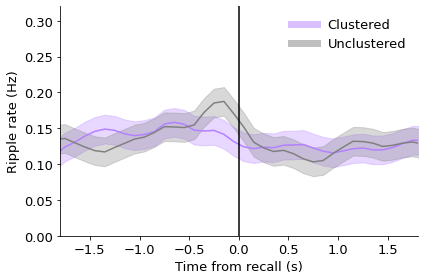

In [185]:
save_plot = 1

constant_error = 0.02

# Configuration parameters
bin_size = 100  # in ms
smoothing_triangle = 5  # triangular smoothing window width
font_size = 13  # Settable font size
bar_ylimits = (0, 0.32)

if remove_low_freq == 1:
    trial_select = ~z_low_gamma_trials
elif remove_low_freq == 2:
    trial_select = ~z_high_gamma_trials
else:
    print('Invalid remove_low_freq selection')
    error    

ripple_swarm_start = int((-ripple_start_offset+ripple_analysis_start)/sr_factor)
ripple_swarm_end = int((-ripple_start_offset+ripple_analysis_end)/sr_factor)
ripple_swarm_duration = (ripple_analysis_end-ripple_analysis_start)/1000  # convert to seconds

# Apply the clust variable to split data into clustered, unclustered, and not recalled
clust_clustered = sub_clust_ID > 1
clust_unclustered = sub_clust_ID < 0

# Calculate ripple means for each condition
mean_ripple_clustered = np.sum(start_array[trial_select & clust_clustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_unclustered = np.sum(start_array[trial_select & clust_unclustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration

# Calculate PSTH for each group
ripple_PSTH_clustered, bin_centers = fullPSTH(start_array[trial_select & clust_clustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_unclustered, _ = fullPSTH(start_array[trial_select & clust_unclustered], bin_size, smoothing_triangle, fs, ripple_start_offset)

# Set up the figure with GridSpec
fig = plt.figure(figsize=(6, 4))
gs = gridspec.GridSpec(1, 1)
ax_psth = fig.add_subplot(gs[0, 0])

# Define the custom colors
if region_name[0] == 'HPC':
    high_clustered_color = (0.0, 0.5, 0.0) # green
elif region_name[0] == 'ENT':
    high_clustered_color = (0.7, 0.5, 1.0) # Light purple
low_clustering_color = 'gray'  

# Plot the PSTH for each group
ax_psth.plot(bin_centers / 1000, ripple_PSTH_clustered, label='Clustered', color=high_clustered_color)
ax_psth.plot(bin_centers / 1000, ripple_PSTH_unclustered, label='Unclustered', color=low_clustering_color)

# Add constant error bands using fill_between
ax_psth.fill_between(bin_centers / 1000, ripple_PSTH_clustered - constant_error, ripple_PSTH_clustered + constant_error,
                     color=high_clustered_color, alpha=0.3, label='_nolegend_')
ax_psth.fill_between(bin_centers / 1000, ripple_PSTH_unclustered - constant_error, ripple_PSTH_unclustered + constant_error,
                     color=low_clustering_color, alpha=0.3, label='_nolegend_')

# Add labels and formatting
ax_psth.axvline(x=0.0, color='black', linestyle='-')
ax_psth.set_xlabel('Time from recall (s)', fontsize=font_size)
ax_psth.set_ylabel('Ripple rate (Hz)', fontsize=font_size)
ax_psth.set_xlim(-1.8, 1.8)
ax_psth.set_ylim(0, bar_ylimits[1])
ax_psth.spines['right'].set_visible(False)
ax_psth.spines['top'].set_visible(False)

# Customize ticks
ax_psth.set_xticks(np.arange(-1.5, 2.0, 0.5))
ax_psth.set_yticks(np.arange(0, 0.35, 0.05))
ax_psth.tick_params(axis='both', labelsize=font_size)
leg = ax_psth.legend(frameon=False, fontsize=font_size)
for legobj in leg.legendHandles:
    legobj.set_linewidth(7.0)
    legobj.set_alpha(0.5)

# Adjust layout and show plot
plt.tight_layout()

if save_plot == 1:
    plt.savefig(f'/home1/john/SWRrefactored/figures/ripple_psths/{task}_{saveName}{region_name[0]}_{subregion[0]}_allTrials.pdf',transparent=True) 

plt.show();
